In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Set the path to the dataset directory
dataset_path = "/content/drive/MyDrive/mayuuri/mayuuri/Road Images"

# Set the image dimensions and batch size
img_height, img_width = 150, 150
batch_size = 32

In [ ]:
# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(root=dataset_path, transform=transform)
dataset_size = len(dataset)
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
dataset.find_classes

<bound method DatasetFolder.find_classes of Dataset ImageFolder
    Number of datapoints: 2242
    Root location: /content/drive/MyDrive/mayuuri/mayuuri/Road Images
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )>

In [ ]:
dataset.classes

['Left Curve',
 'Pot Holes',
 'Right Curve',
 'S Curved',
 'Snow Covered',
 'Straight Roads']

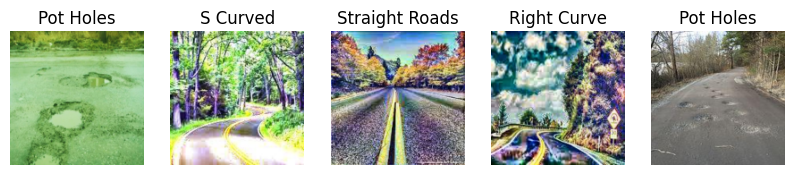

In [ ]:
# Display sample set of training images
sample_loader = next(iter(train_loader))
sample_images, sample_labels = sample_loader

fig = plt.figure(figsize=(10, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    image = sample_images[i] / 2 + 0.5  # unnormalize
    np_image = image.numpy()
    class_name = dataset.classes[sample_labels[i]]  # Get class name from dataset
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    ax.set_title(f"{class_name}")
    ax.axis('off')

plt.show()

In [8]:
import torch.nn.functional as F
# Build and train the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 17 * 17, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

Epoch [1/10], Train Accuracy: 44.42%, Val Accuracy: 71.56%
Epoch [2/10], Train Accuracy: 88.00%, Val Accuracy: 95.56%
Epoch [3/10], Train Accuracy: 97.52%, Val Accuracy: 97.78%
Epoch [4/10], Train Accuracy: 99.41%, Val Accuracy: 96.89%
Epoch [5/10], Train Accuracy: 98.96%, Val Accuracy: 96.44%
Epoch [6/10], Train Accuracy: 99.31%, Val Accuracy: 100.00%
Epoch [7/10], Train Accuracy: 99.85%, Val Accuracy: 100.00%
Epoch [8/10], Train Accuracy: 100.00%, Val Accuracy: 100.00%
Epoch [9/10], Train Accuracy: 100.00%, Val Accuracy: 100.00%
Epoch [10/10], Train Accuracy: 100.00%, Val Accuracy: 100.00%


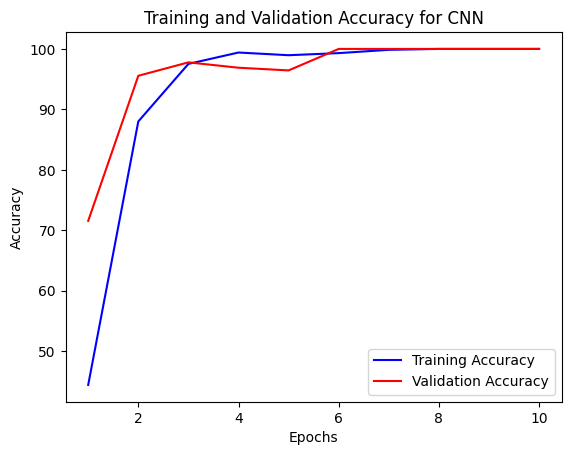

In [ ]:
# Training the CNN model
num_epochs = 10
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model_cnn.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracy_history.append(train_accuracy)

    model_cnn.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        val_labels = []
        val_predictions = []
        for images, labels in val_loader:
            outputs = model_cnn(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_labels.extend(labels.tolist())
            val_predictions.extend(predicted.tolist())

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_history.append(val_accuracy)
    confusion = confusion_matrix(val_labels, val_predictions)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

# Plot the training and validation accuracy curves
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracy_history, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

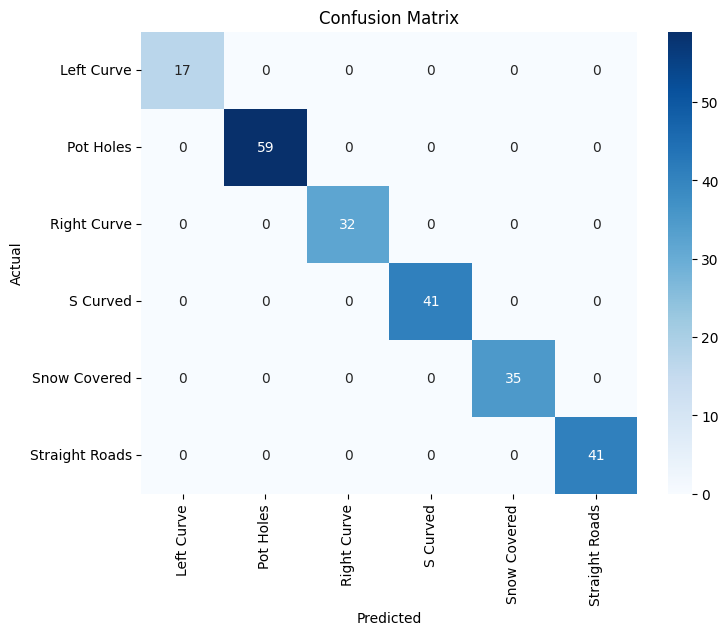

In [ ]:
# Plot the confusion matrix using seaborn
class_labels = ['Left Curve',
 'Pot Holes',
 'Right Curve',
 'S Curved',
 'Snow Covered',
 'Straight Roads']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.1MB/s]


Epoch [1/10], Transfer Learning Train Accuracy: 85.08%, Transfer Learning Val Accuracy: 95.56%
Epoch [2/10], Transfer Learning Train Accuracy: 96.18%, Transfer Learning Val Accuracy: 90.67%
Epoch [3/10], Transfer Learning Train Accuracy: 96.98%, Transfer Learning Val Accuracy: 98.67%
Epoch [4/10], Transfer Learning Train Accuracy: 96.83%, Transfer Learning Val Accuracy: 99.56%
Epoch [5/10], Transfer Learning Train Accuracy: 97.97%, Transfer Learning Val Accuracy: 99.56%
Epoch [6/10], Transfer Learning Train Accuracy: 99.06%, Transfer Learning Val Accuracy: 100.00%
Epoch [7/10], Transfer Learning Train Accuracy: 98.81%, Transfer Learning Val Accuracy: 97.78%
Epoch [8/10], Transfer Learning Train Accuracy: 97.57%, Transfer Learning Val Accuracy: 100.00%
Epoch [9/10], Transfer Learning Train Accuracy: 98.26%, Transfer Learning Val Accuracy: 99.56%
Epoch [10/10], Transfer Learning Train Accuracy: 98.66%, Transfer Learning Val Accuracy: 100.00%


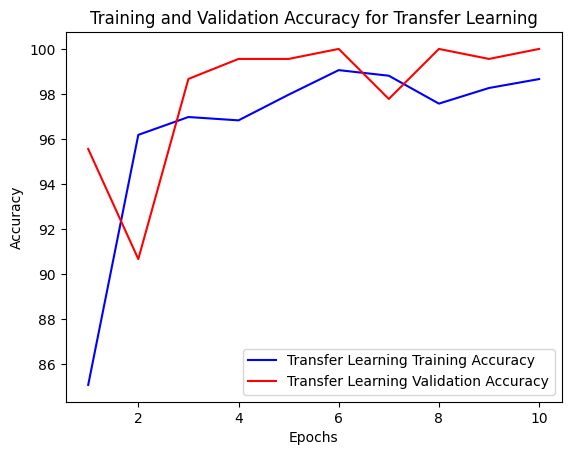

In [ ]:
# Transfer learning using pre-trained model
import torchvision.models as models

base_model = models.mobilenet_v2(pretrained=True)
in_features = base_model.classifier[1].in_features
base_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 6)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)

# Training the transfer learning model
transfer_train_accuracy_history = []
transfer_val_accuracy_history = []

for epoch in range(num_epochs):
    base_model.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = base_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    transfer_train_accuracy_history.append(train_accuracy)

    base_model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        val_labels = []
        val_predictions = []
        for images, labels in val_loader:
            outputs = base_model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_labels.extend(labels.tolist())
            val_predictions.extend(predicted.tolist())
    val_accuracy = 100 * val_correct / val_total
    transfer_val_accuracy_history.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Transfer Learning Train Accuracy: {train_accuracy:.2f}%, Transfer Learning Val Accuracy: {val_accuracy:.2f}%")

# Plot the training and validation accuracy curves for transfer learning
plt.plot(epochs, transfer_train_accuracy_history, 'b', label='Transfer Learning Training Accuracy')
plt.plot(epochs, transfer_val_accuracy_history, 'r', label='Transfer Learning Validation Accuracy')
plt.title('Training and Validation Accuracy for Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


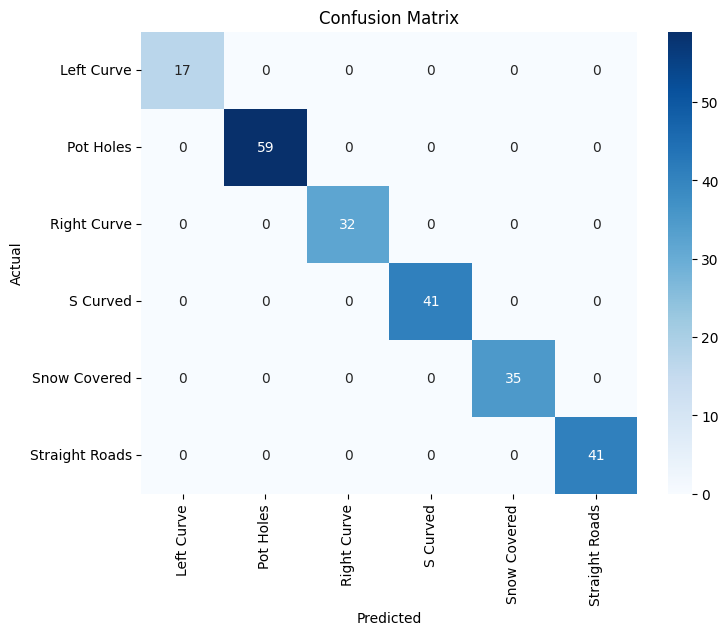

In [ ]:
confusion = confusion_matrix(val_labels, val_predictions)

class_labels = ['Left Curve',
 'Pot Holes',
 'Right Curve',
 'S Curved',
 'Snow Covered',
 'Straight Roads']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Saving the trained model
torch.save(base_model.state_dict(), '/content/drive/MyDrive/mayuuri/mayuuri/models_torch/cnn_trained_model.pth')
torch.save(model_cnn.state_dict(), '/content/drive/MyDrive/mayuuri/mayuuri/models_torch/cnn_trained_model1.pth')

In [ ]:
# Evaluating the models
model_cnn.load_state_dict(torch.load('/content/drive/MyDrive/mayuuri/mayuuri/models_torch/cnn_trained_model.pth'))
base_model.load_state_dict(torch.load('/content/drive/MyDrive/mayuuri/mayuuri/models_torch/cnn_trained_model.pth'))

In [ ]:

model_cnn.eval()
base_model.eval()

cnn_correct = 0
cnn_total = 0

transfer_correct = 0
transfer_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        # CNN Model
        outputs_cnn = model_cnn(images)
        _, predicted_cnn = torch.max(outputs_cnn, 1)
        cnn_total += labels.size(0)
        cnn_correct += (predicted_cnn == labels).sum().item()

        # Transfer Learning Model
        outputs_transfer = base_model(images)
        _, predicted_transfer = torch.max(outputs_transfer, 1)
        transfer_total += labels.size(0)
        transfer_correct += (predicted_transfer == labels).sum().item()

cnn_accuracy = 100 * cnn_correct / cnn_total
transfer_accuracy = 100 * transfer_correct / transfer_total

print("CNN Model - Accuracy:", cnn_accuracy)
# print("Transfer Learning Model - Accuracy:", transfer_accuracy)

CNN Model - Accuracy: 100.0


### Testing

In [13]:
import torch
checkpoint = torch.load('/content/drive/MyDrive/mayuuri/models_torch/cnn_trained_model.pth')
model_cnn.load_state_dict(checkpoint)
model_cnn.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36992, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

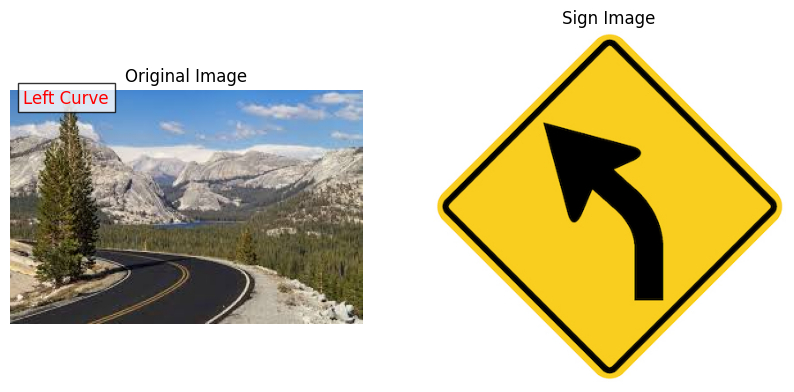

In [15]:
# Testing

image_mapping = {
  'Left Curve':'LeftCurve.jpg',
 'S Curved':'SCurve.jpg',
 'Snow Covered':'IceCovered_Road.png',
 'Pot Holes':'Potholes.jpg',
 'Right Curve':'RightCurve.jpg',
 'Straight Roads':'StraightRoad_SpeedSign.jpg'}

def display_side_by_side_images(image_path, sign_path, predicted_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Load and display the original image
    test_image = Image.open(image_path)
    axs[0].imshow(test_image)
    axs[0].axis('off')
    axs[0].set_title(f"Original Image")

    # Add predicted label to the image
    axs[0].text(10, 10, predicted_label, fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.8))

    # Load and display the sign image
    sign_image = Image.open(sign_path)
    axs[1].imshow(sign_image)
    axs[1].axis('off')
    axs[1].set_title(f"Sign Image")

    plt.show()


def get_sign(img_path, model):
    test_transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_image = Image.open(img_path)
    test_image = test_transform(test_image).unsqueeze(0)

    with torch.no_grad():
        model.eval()
        outputs = model(test_image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()

    class_mapping = {0: 'Left Curve', 1: 'Pot Holes', 2: 'Snow Covered', 3: 'S Curved', 4: 'Right Curve', 5: 'Straight Roads'}
    predicted_label = class_mapping[class_idx]
    return predicted_label

img_path = '/content/drive/MyDrive/mayuuri/testing/left1.jpg'
transfer_predicted_label = get_sign(img_path, model_cnn)
sign_name = os.path.join('/content/drive/MyDrive/mayuuri/signs', image_mapping[transfer_predicted_label])
display_side_by_side_images(img_path, sign_name, transfer_predicted_label)

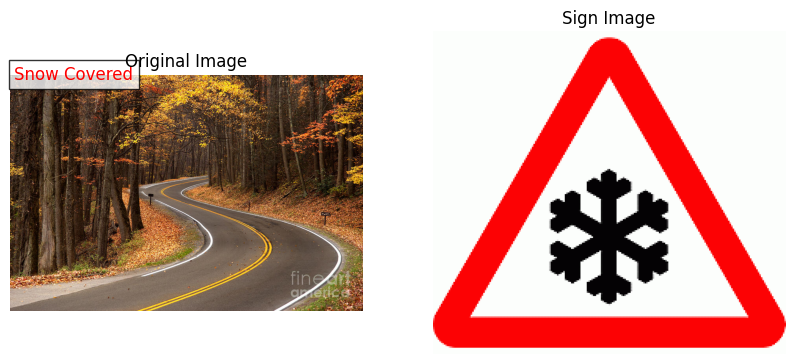

In [ ]:
img_path = '/content/drive/MyDrive/Rajendra/testing/s_curve1.jpg'
transfer_predicted_label = get_sign(img_path, model_cnn)
sign_name = os.path.join('/content/drive/MyDrive/Rajendra/signs', image_mapping[transfer_predicted_label])
display_side_by_side_images(img_path, sign_name, transfer_predicted_label)

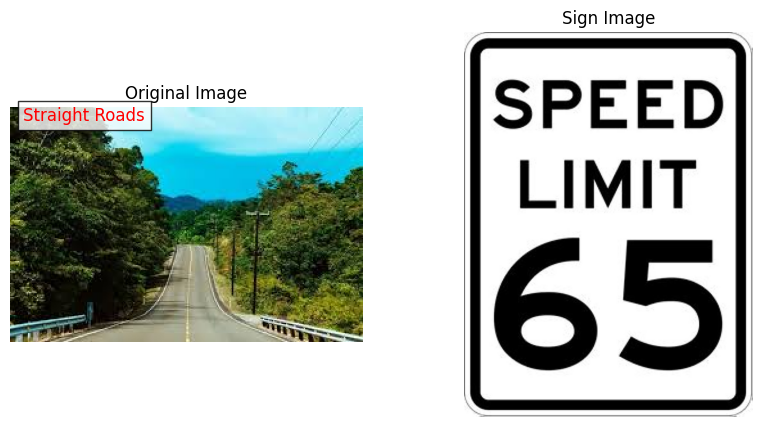

In [ ]:
img_path = '/content/drive/MyDrive/Rajendra/testing/stright1.jpg'
transfer_predicted_label = get_sign(img_path, model_cnn)
sign_name = os.path.join('/content/drive/MyDrive/Rajendra/signs', image_mapping[transfer_predicted_label])
display_side_by_side_images(img_path, sign_name, transfer_predicted_label)

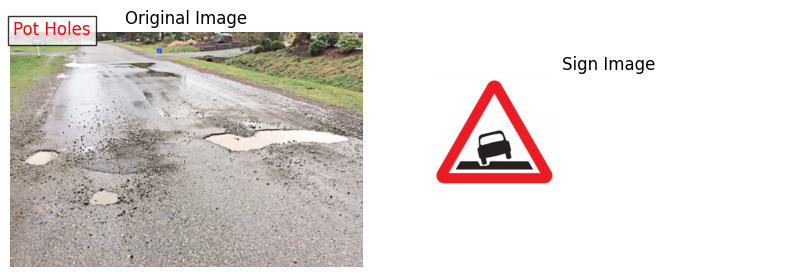

In [ ]:
img_path = '/content/drive/MyDrive/Rajendra/testing/damage.jpg'
transfer_predicted_label = get_sign(img_path, model_cnn)
sign_name = os.path.join('/content/drive/MyDrive/Rajendra/signs', image_mapping[transfer_predicted_label])
display_side_by_side_images(img_path, sign_name, transfer_predicted_label)

In [ ]:
## Model is performing good when coming to scurve,right and stright road. but